In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
!pip install lightning
!pip install pytorch-forecasting --extra-index-url https://download.pytorch.org/whl/cpu

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss
import yfinance as yf
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 69.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.8/399.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
tickers = ["AAPL", "GOOGL", "MSFT", "TSLA", "AMZN", "NVDA"]
data = yf.download(tickers, start="2020-01-19", end="2026-01-19")

[*********************100%***********************]  6 of 6 completed


In [ ]:
data

Price            Close                                                  \
Ticker            AAPL        AMZN       GOOGL        MSFT        NVDA   
Date                                                                     
2020-01-21   76.381821   94.599998   73.556725  158.088669    6.170934   
2020-01-22   76.654465   94.373001   73.637108  157.329041    6.224943   
2020-01-23   77.023613   94.228996   73.677803  158.297501    6.293387   
2020-01-24   76.801628   93.082001   72.758759  156.702423    6.234153   
2020-01-27   74.543266   91.417000   71.049667  154.081833    5.978296   
...                ...         ...         ...         ...         ...   
2026-01-12  260.250000  246.470001  331.859985  477.179993  184.940002   
2026-01-13  261.049988  242.600006  335.970001  470.670013  185.809998   
2026-01-14  259.959991  236.649994  335.839996  459.380005  183.139999   
2026-01-15  258.209991  238.179993  332.779999  456.660004  187.050003   
2026-01-16  255.529999  239.119995  330.000000  459.859985  186.229996   

Price                         High                                      ...  \
Ticker            TSLA        AAPL        AMZN       GOOGL        MSFT  ...   
Date                                                                    ...   
2020-01-21   36.480000   76.972951   94.713501   73.935364  159.693295  ...   
2020-01-22   37.970669   77.206989   95.125000   74.466345  159.028620  ...   
2020-01-23   38.146667   77.103232   94.499001   74.115006  158.373461  ...   
2020-01-24   37.654667   78.012848   94.749496   74.149746  159.066637  ...   
2020-01-27   37.201332   75.223669   92.050003   71.290349  155.126268  ...   
...                ...         ...         ...         ...         ...  ...   
2026-01-12  448.959991  261.299988  248.940002  334.040009  480.989990  ...   
2026-01-13  447.200012  261.809998  247.660004  340.489990  475.779999  ...   
2026-01-14  439.200012  261.820007  241.279999  336.519989  468.200012  ...   
2026-01-15  438.570007  261.040009  240.649994  337.690002  464.250000  ...   
2026-01-16  437.500000  258.899994  239.570007  334.649994  463.190002  ...   

Price             Open                                         Volume  \
Ticker           GOOGL        MSFT        NVDA        TSLA       AAPL   
Date                                                                    
2020-01-21   73.395437  158.259569    6.167698   35.349998  110843200   
2020-01-22   73.927917  158.943156    6.216232   38.125999  101832400   
2020-01-23   73.819736  157.794277    6.265014   37.616669  104472000   
2020-01-24   74.081263  159.047644    6.408872   38.042000  146537600   
2020-01-27   71.040240  153.008914    5.929514   36.132668  161940000   
...                ...         ...         ...         ...        ...   
2026-01-12  325.799988  476.670013  183.220001  441.230011   45263800   
2026-01-13  334.950012  474.679993  185.000000  450.200012   45730800   
2026-01-14  335.059998  466.459991  184.320007  442.809998   40019400   
2026-01-15  337.649994  464.119995  186.500000  441.130005   39388600   
2026-01-16  334.410004  457.829987  189.080002  439.500000   72142800   

Price                                                           
Ticker          AMZN     GOOGL      MSFT       NVDA       TSLA  
Date                                                            
2020-01-21  74156000  48930000  29517200  217916000  267052500  
2020-01-22  64326000  28458000  24138800  239240000  470535000  
2020-01-23  49692000  26650000  19680800  244516000  294765000  
2020-01-24  75324000  29786000  24918100  373512000  215304000  
2020-01-27  70570000  34132000  32078100  470536000  204121500  
...              ...       ...       ...        ...        ...  
2026-01-12  35867800  33923900  23519900  137968500   61649600  
2026-01-13  38371800  33517600  28545800  160128900   53719200  
2026-01-14  41410600  28525600  28184300  159586100   57259500  
2026-01-15  43003600  28442400  23225800  206188600  

In [ ]:
df = data['Close'].stack().reset_index()

In [ ]:
df

,Date,Ticker,0
0,2020-01-21,AAPL,76.381821
1,2020-01-21,AMZN,94.599998
2,2020-01-21,GOOGL,73.556725
3,2020-01-21,MSFT,158.088669
4,2020-01-21,NVDA,6.170934
...,...,...,...
9037,2026-01-16,AMZN,239.119995
9038,2026-01-16,GOOGL,330.000000
9039,2026-01-16,MSFT,459.859985
9040,2026-01-16,NVDA,186.229996


In [ ]:
df.columns = ['date', 'symbol', 'price']

In [ ]:
df

,date,symbol,price
0,2020-01-21,AAPL,76.381821
1,2020-01-21,AMZN,94.599998
2,2020-01-21,GOOGL,73.556725
3,2020-01-21,MSFT,158.088669
4,2020-01-21,NVDA,6.170934
...,...,...,...
9037,2026-01-16,AMZN,239.119995
9038,2026-01-16,GOOGL,330.000000
9039,2026-01-16,MSFT,459.859985
9040,2026-01-16,NVDA,186.229996


In [ ]:
df = df.sort_values(['symbol', 'date'])

In [ ]:
df

,date,symbol,price
0,2020-01-21,AAPL,76.381821
6,2020-01-22,AAPL,76.654465
12,2020-01-23,AAPL,77.023613
18,2020-01-24,AAPL,76.801628
24,2020-01-27,AAPL,74.543266
...,...,...,...
9017,2026-01-12,TSLA,448.959991
9023,2026-01-13,TSLA,447.200012
9029,2026-01-14,TSLA,439.200012
9035,2026-01-15,TSLA,438.570007


In [ ]:
df['time_idx'] = df.groupby('symbol').cumcount()

In [ ]:
df

,date,symbol,price,time_idx
0,2020-01-21,AAPL,76.381821,0
6,2020-01-22,AAPL,76.654465,1
12,2020-01-23,AAPL,77.023613,2
18,2020-01-24,AAPL,76.801628,3
24,2020-01-27,AAPL,74.543266,4
...,...,...,...,...
9017,2026-01-12,TSLA,448.959991,1502
9023,2026-01-13,TSLA,447.200012,1503
9029,2026-01-14,TSLA,439.200012,1504
9035,2026-01-15,TSLA,438.570007,1505


In [ ]:
type(df['symbol'])

pandas.core.series.Series

In [ ]:
df['symbol'] = df['symbol'].astype(str)

In [ ]:
df['month'] = df['date'].dt.month.astype(str)
df['day'] = df['date'].dt.dayofweek.astype(str)
df

,date,symbol,price,time_idx,month,day
0,2020-01-21,AAPL,76.381821,0,1,1
6,2020-01-22,AAPL,76.654465,1,1,2
12,2020-01-23,AAPL,77.023613,2,1,3
18,2020-01-24,AAPL,76.801628,3,1,4
24,2020-01-27,AAPL,74.543266,4,1,0
...,...,...,...,...,...,...
9017,2026-01-12,TSLA,448.959991,1502,1,0
9023,2026-01-13,TSLA,447.200012,1503,1,1
9029,2026-01-14,TSLA,439.200012,1504,1,2
9035,2026-01-15,TSLA,438.570007,1505,1,3


In [ ]:
max_prediction_length = 7
max_encoder_length = 90
training_cutoff = df["time_idx"].max() - max_prediction_length

In [ ]:
training = TimeSeriesDataSet(
    df[lambda x : x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target = 'price',
    group_ids = ["symbol"],
    static_categoricals=['symbol'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['price'],
    time_varying_known_categoricals=['month', 'day'],
    target_normalizer=GroupNormalizer(
        groups=["symbol"], transformation="softplus"
    )
    )

In [ ]:
validation = TimeSeriesDataSet.from_dataset(
    training, df, min_prediction_idx=training_cutoff + 1
)

In [ ]:
batch_size = 256

In [ ]:
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2, batch_sampler="synchronized", pin_memory = True
)

In [ ]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized", pin_memory=True
)

In [ ]:
baseline_predictions = Baseline().predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True
)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


tensor(0.0210)

In [ ]:
baseline_predictions

Prediction(output=tensor([[260.3300, 260.3300, 260.3300, 260.3300, 260.3300, 260.3300, 260.3300],
        [241.5600, 241.5600, 241.5600, 241.5600, 241.5600, 241.5600, 241.5600],
        [321.9800, 321.9800, 321.9800, 321.9800, 321.9800, 321.9800, 321.9800],
        [483.4700, 483.4700, 483.4700, 483.4700, 483.4700, 483.4700, 483.4700],
        [189.1100, 189.1100, 189.1100, 189.1100, 189.1100, 189.1100, 189.1100],
        [431.4100, 431.4100, 431.4100, 431.4100, 431.4100, 431.4100, 431.4100]]), x=None, index=None, decoder_lengths=None, y=(tensor([[259.0400, 259.3700, 260.2500, 261.0500, 259.9600, 258.2100, 255.5300],
        [246.2900, 247.3800, 246.4700, 242.6000, 236.6500, 238.1800, 239.1200],
        [325.4400, 328.5700, 331.8600, 335.9700, 335.8400, 332.7800, 330.0000],
        [478.1100, 479.2800, 477.1800, 470.6700, 459.3800, 456.6600, 459.8600],
        [185.0400, 184.8600, 184.9400, 185.8100, 183.1400, 187.0500, 186.2300],
        [435.8000, 445.0100, 448.9600, 447.2000, 439.20

In [ ]:
baseline_predictions.output

tensor([[260.3300, 260.3300, 260.3300, 260.3300, 260.3300, 260.3300, 260.3300],
        [241.5600, 241.5600, 241.5600, 241.5600, 241.5600, 241.5600, 241.5600],
        [321.9800, 321.9800, 321.9800, 321.9800, 321.9800, 321.9800, 321.9800],
        [483.4700, 483.4700, 483.4700, 483.4700, 483.4700, 483.4700, 483.4700],
        [189.1100, 189.1100, 189.1100, 189.1100, 189.1100, 189.1100, 189.1100],
        [431.4100, 431.4100, 431.4100, 431.4100, 431.4100, 431.4100, 431.4100]])

In [ ]:
baseline_predictions.y

(tensor([[259.0400, 259.3700, 260.2500, 261.0500, 259.9600, 258.2100, 255.5300],
         [246.2900, 247.3800, 246.4700, 242.6000, 236.6500, 238.1800, 239.1200],
         [325.4400, 328.5700, 331.8600, 335.9700, 335.8400, 332.7800, 330.0000],
         [478.1100, 479.2800, 477.1800, 470.6700, 459.3800, 456.6600, 459.8600],
         [185.0400, 184.8600, 184.9400, 185.8100, 183.1400, 187.0500, 186.2300],
         [435.8000, 445.0100, 448.9600, 447.2000, 439.2000, 438.5700, 437.5000]]),
 None)

In [ ]:
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=128,
    log_interval=10,
    log_val_interval=1,
    rnn_layers=3,
    loss=MultivariateNormalDistributionLoss(rank=3),
    optimizer="Adam",
)

In [ ]:
from pytorch_forecasting.tuning import Tuner

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: `weights_only` was not set, defaulting to `False`.
INFO:lightning.pytorch.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Restoring states from the checkpoint path at /content/.lr_find_9362de7f-41db-466e-b052-2044dceffb81.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_9362de7f-41db-466e-b052-2044dceffb81.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_9362de7f-41db-466e-b052-2044dceffb81.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_9362de7f-41db-466e-b052-2044dceffb81.ckpt
INFO: Learning rate set to 3.981071705534973e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 3.981071705534973e-05


In [ ]:
print(f"The learning rate for the DeepAR model is: {net.hparams.learning_rate}")

The learning rate for the DeepAR model is: 3.981071705534973e-05


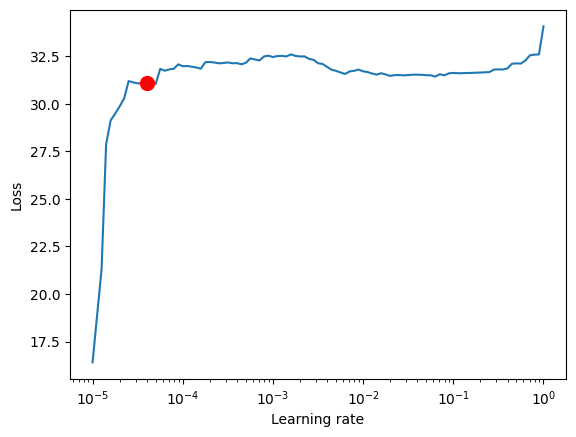

In [ ]:
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-3, patience=5, verbose=True, mode="min"
)
#Prevents overfitting

In [ ]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
)


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                   ┃ Type                               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                   │ MultivariateNormalDistributionLoss │      0 │ train │     0 │
│ 1 │ logging_metrics        │ ModuleList                         │      0 │ train │     0 │
│ 2 │ embeddings             │ MultiEmbedding                     │    116 │ train │     0 │
│ 3 │ rnn                    │ LSTM                               │  338 K │ train │     0 │
│ 4 │ distribution_projector │ Linear                             │    645 │ train │     0 │
└───┴────────────────────────┴────────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 339 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 339 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 14                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: Metric val_loss improved. New best score: 30.238
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 30.238
INFO: Metric val_loss improved by 5.077 >= min_delta = 0.001. New best score: 25.161
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 5.077 >= min_delta = 0.001. New best score: 25.161
INFO: Metric val_loss improved by 0.245 >= min_delta = 0.001. New best score: 24.916
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.245 >= min_delta = 0.001. New best score: 24.916
INFO: Metric val_loss improved by 0.343 >= min_delta = 0.001. New best score: 24.572
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.343 >= min_delta = 0.001. New best score: 24.572
INFO: Metric val_loss improved by 1.083 >= min_delta = 0.001. New best score: 23.489
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.083 >= min_delta = 0.001. New best score: 23.489


In [ ]:
!zip -r lightning_logs.zip lightning_logs/

updating: lightning_logs/ (stored 0%)
updating: lightning_logs/version_0/ (stored 0%)
updating: lightning_logs/version_0/hparams.yaml (deflated 71%)
updating: lightning_logs/version_0/events.out.tfevents.1769453750.1351b92e4b9d.1742.0 (deflated 44%)
updating: lightning_logs/version_2/ (stored 0%)
updating: lightning_logs/version_2/checkpoints/ (stored 0%)
updating: lightning_logs/version_2/checkpoints/epoch=40-step=57564.ckpt (deflated 8%)
updating: lightning_logs/version_2/hparams.yaml (deflated 79%)
updating: lightning_logs/version_2/events.out.tfevents.1769453779.1351b92e4b9d.1742.2 (deflated 10%)
updating: lightning_logs/version_1/ (stored 0%)
updating: lightning_logs/version_1/hparams.yaml (stored 0%)
updating: lightning_logs/version_1/events.out.tfevents.1769453751.1351b92e4b9d.1742.1 (deflated 9%)
  adding: lightning_logs/version_4/ (stored 0%)
  adding: lightning_logs/version_4/hparams.yaml (deflated 79%)
  adding: lightning_logs/version_4/events.out.tfevents.1769456401.1351b92

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")

# Load the model directly from that path
best_model = DeepAR.load_from_checkpoint(best_model_path)

Loading best model from: /content/lightning_logs/version_2/checkpoints/epoch=40-step=57564.ckpt


In [ ]:
best_model.eval()

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'price', 'group_ids': ['symbol'], 'weight': None, 'max_encoder_length': 90, 'min_encoder_length': 90, 'min_prediction_idx': 0, 'min_prediction_length': 7, 'max_prediction_length': 7, 'static_categoricals': ['symbol'], 'static_reals': None, 'time_varying_known_categoricals': ['month', 'day'], 'time_varying_known_reals': None, 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['price'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': False, 'add_target_scales': False, 'add_encoder_length': False, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		groups=['symbol'],
  		center=True,
  		scale_by_group=False,
  		transformation='softplus',
  		method_kwargs={}
  	), 'categorical_encoders': {'__group_id__s

In [ ]:
# 1. Generate predictions on the GPU
preds = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)

# 2. Move metrics to the GPU before calculating
mae_val = MAE()(preds.output, preds.y)
smape_val = SMAPE()(preds.output, preds.y)

print(f"GPU-Accelerated MAE: {mae_val}")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


GPU-Accelerated MAE: 7.643550872802734


In [ ]:
raw_predictions = best_model.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu"),
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


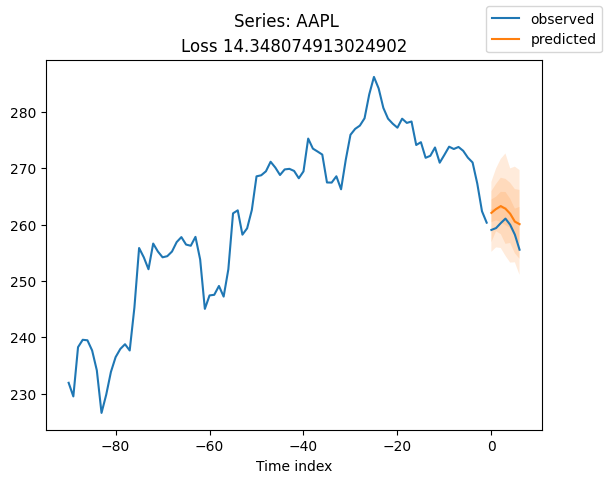

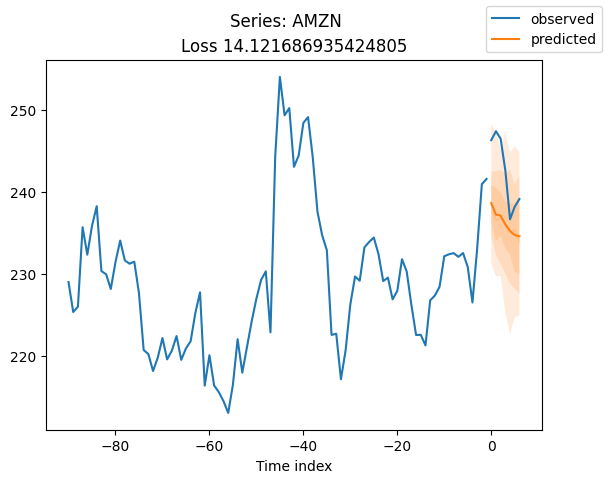

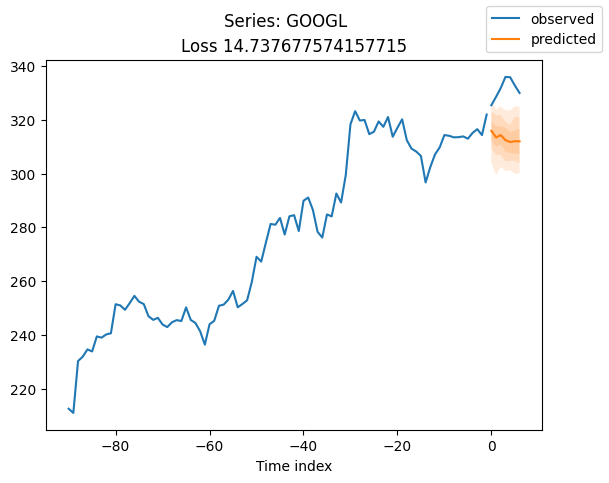

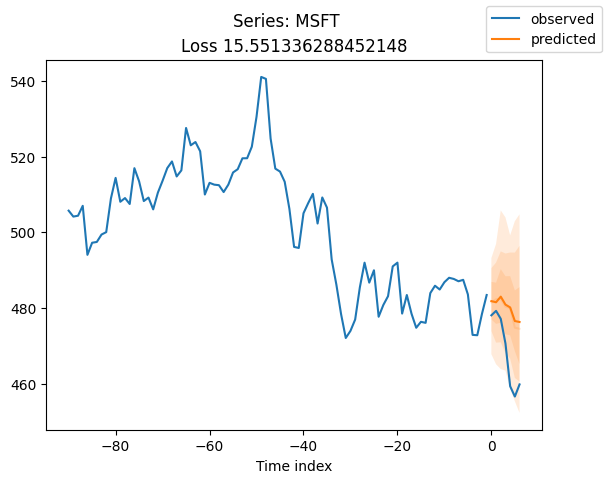

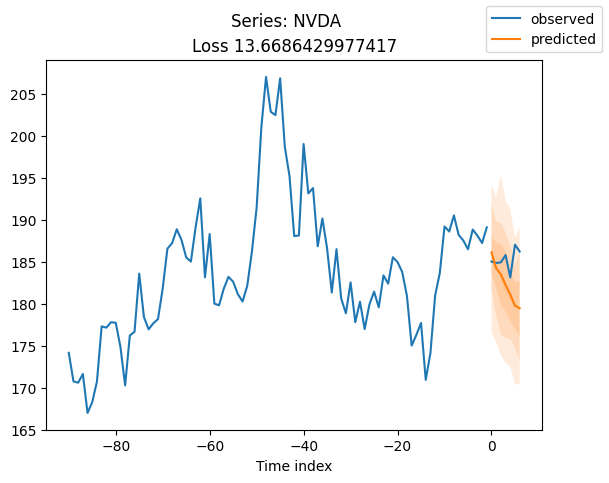

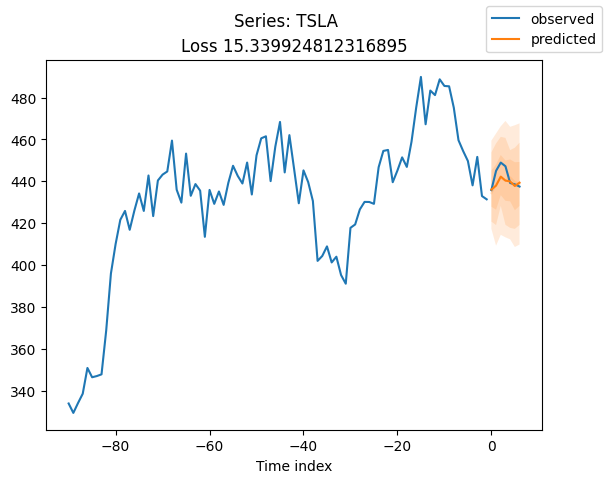

In [ ]:
series = validation.x_to_index(raw_predictions.x)["symbol"]
for idx in range(6):  # plot 10 examples
    best_model.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )
    plt.suptitle(f"Series: {series.iloc[idx]}")